In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout,InputLayer,MaxPool2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy,mean_squared_error,mean_absolute_error
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
lenc = LabelEncoder()
ohe = OneHotEncoder()

In [2]:
DATA_DIR = 'data'
IMAGE_DIR = f'../{DATA_DIR}/dataset'

image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2
    )

data_train = image_generator.flow_from_directory(
    IMAGE_DIR,
    target_size=(128,128),
    batch_size=256,
    class_mode='categorical',
    shuffle=True,
    subset = 'training'   
)

data_val = image_generator.flow_from_directory(
    IMAGE_DIR,
    target_size=(128,128),
    batch_size=256,
    class_mode='categorical',
    shuffle=True,
    subset = 'validation'   
)

N_CLASSES = data_train.num_classes

Found 4146 images belonging to 5 classes.
Found 1034 images belonging to 5 classes.


In [3]:
IMSIZE = (128,128,3)
N_CLASSES = data_train.num_classes

In [4]:
model = Sequential()
model.add(InputLayer(input_shape=IMSIZE))
model.add(Conv2D(64,(5,5),activation='relu',strides=(2,2),padding='same'))
model.add(Conv2D(64,(3,3),activation='relu',strides=(2,2),padding='same'))

model.add(Conv2D(64,(1,1),activation='relu',padding='same'))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128,(1,1),activation='relu',padding='same'))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256,(1,1),activation='relu',padding='same'))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(Conv2D(512,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(1024,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(N_CLASSES,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])



2022-07-09 01:55:10.668695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 01:55:10.674117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 01:55:10.674393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 01:55:10.674919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

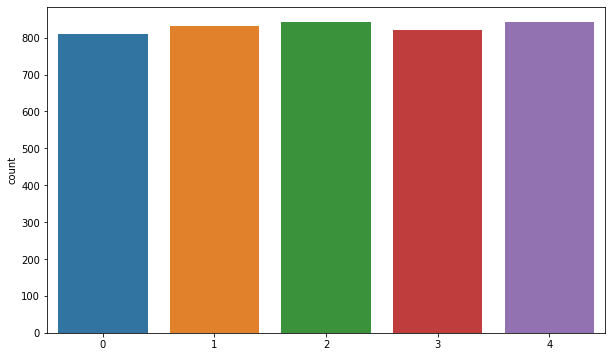

In [5]:
y = data_train.labels

plt.figure("countplot",figsize=(10,6))
sns.countplot(x=y.flatten())
plt.show()

In [7]:
model.optimizer.lr = 0.0001
model.optimizer.momentum = 0.9
with tf.device('/gpu:0'):
    history = model.fit_generator(data_train,epochs=100,validation_data=data_val)

/tmp/ipykernel_110508/1414883363.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_train,epochs=100,validation_data=data_val)


Epoch 1/100
17/17 [==============================] - 16s 944ms/step - loss: 1.5968 - accuracy: 0.2453 - val_loss: 1.5904 - val_accuracy: 0.2437
Epoch 2/100
17/17 [==============================] - 17s 980ms/step - loss: 1.4968 - accuracy: 0.3355 - val_loss: 1.4240 - val_accuracy: 0.4139
Epoch 3/100
17/17 [==============================] - 16s 940ms/step - loss: 1.3631 - accuracy: 0.4243 - val_loss: 1.2891 - val_accuracy: 0.4932
Epoch 4/100
17/17 [==============================] - 16s 948ms/step - loss: 1.2369 - accuracy: 0.4884 - val_loss: 1.1199 - val_accuracy: 0.5348
Epoch 5/100
17/17 [==============================] - 16s 948ms/step - loss: 1.1044 - accuracy: 0.5560 - val_loss: 0.9754 - val_accuracy: 0.5996
Epoch 6/100
17/17 [==============================] - 16s 1s/step - loss: 0.9983 - accuracy: 0.6013 - val_loss: 0.9194 - val_accuracy: 0.6122
Epoch 7/100
17/17 [==============================] - 16s 950ms/step - loss: 0.9249 - accuracy: 0.6300 - val_loss: 0.8740 - val_accuracy: 0.

In [8]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

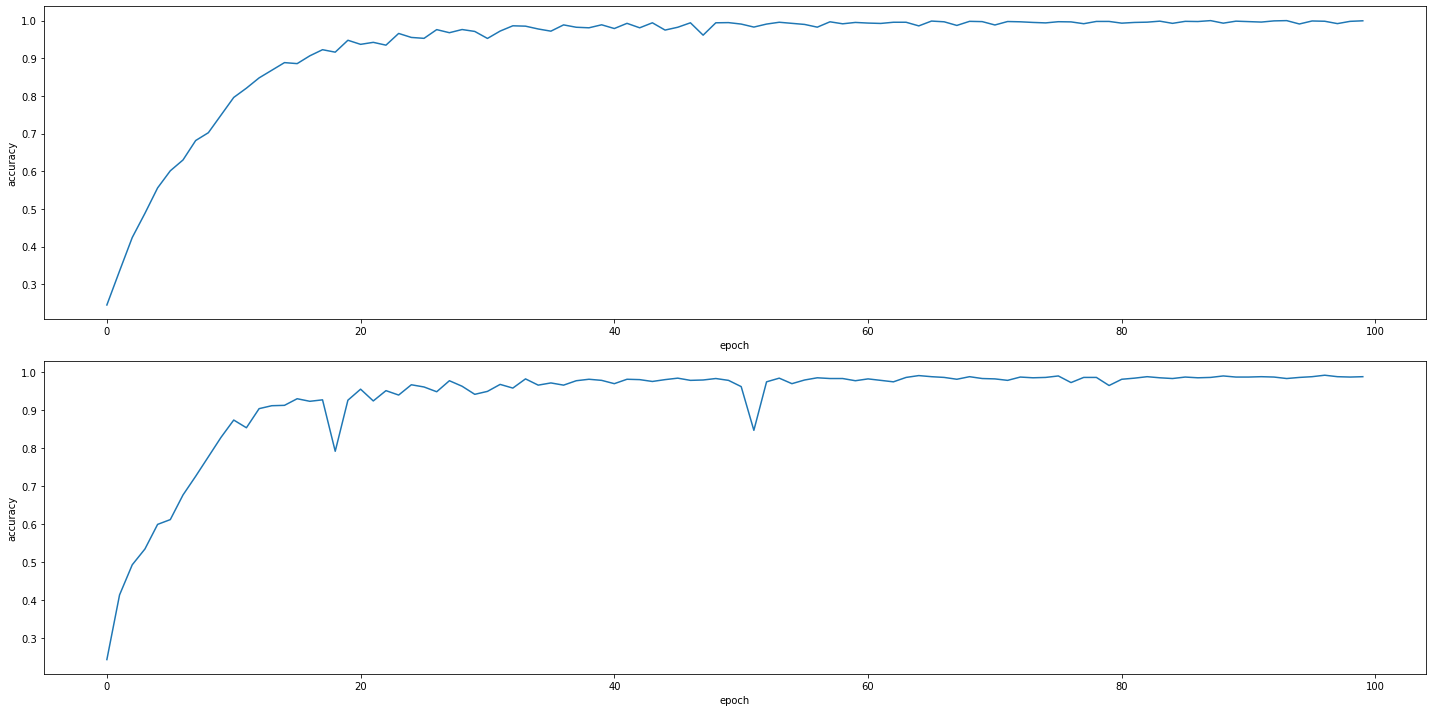

In [9]:
plt.figure("Model Metrics",(20,10))
plt.title('model accuracy')
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(2,1,2)
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()


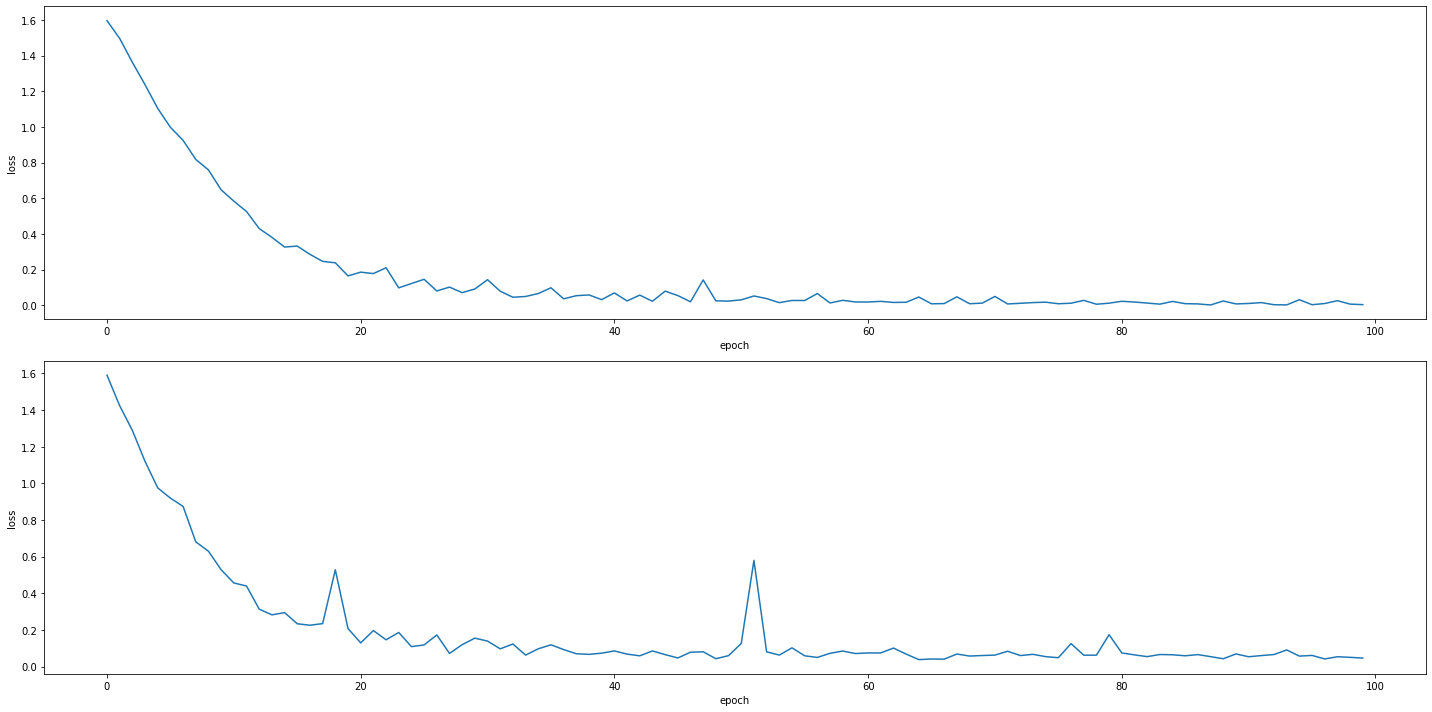

In [12]:
plt.figure("Model Metrics",(20,10))
plt.title('model accuracy')
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(2,1,2)
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()


In [13]:
model.save('../model/saved/scratch_model.h5')